# 장애인콜택시 대기시간 예측
## 단계1.데이터 전처리

## 0.미션

* 1.데이터를 탐색하며 정보 획득
    * 데이터는 2015-01-01 ~ 2022-12-31 까지의 서울 장애인 콜택시 운행 정보입니다. 우리는 평균대기시간을 예측하고자 합니다. 
    * 요일, 월, 계절, 연도별 운행 정보에 어떤 주기와 변화가 있는지 탐색해 봅시다.
* 2.분석을 위한 데이터 구조 만들기
    * 문제정의 : 
        * 전 날 콜택시 운행이 종료되었을 때, 다음 날 대기시간을 예측하고자 합니다.

        * 만약 다음 날 대기시간을 예측할 수 있다면, 일정 범위 내에서 배차를 조절할 수 있을 뿐만 아니라, 향후 교통약자의 이동 편의 증진을 위한 정책 수립 및 개선에 기여할 수 있습니다. 
    * 이를 위한 데이터 구조를 만들어 봅시다.
        * 분석 단위는 일별 데이터 입니다.
        * 주어진 데이터 : 장애인 콜택시 운행 정보, 서울시 날씨
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전 날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
        * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙여서 만듭시다.
        * 휴무일 데이터는 패키지를 통해서 다운받아 사용합니다.
    * Feature Engineering
        * 대기시간에 영향을 주는 요인을 도출하고(가설수립) 이를 feature로 생성합시다.
        * 주어진 그대로의 데이터가 아닌 새로운 feature를 생성해 봅시다.
            * 날짜와 관련된 feature : 요일, 월, 계절 ... 
            * 시계열 특성이 반영된 feature : 최근 7일간의 평균 대기시간 ...




## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 다음의 두가지 방법 중 하나를 선택하여 폴더를 준비하고 데이터를 로딩하시오.
        * 1) 로컬 수행(Ananconda)
            * 제공된 압축파일을 다운받아 압축을 풀고
            * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
        * 2) 구글콜랩
            * 구글 드라이브 바로 밑에 project 폴더를 만들고, 
            * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 설치 및 로딩
        * requirements.txt 파일로 부터 라이브러리 설치
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다. 
        * 필요하다고 판단되는 라이브러리를 추가하세요.

### (1) 경로 설정

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [142]:
# path = 'C:/Users/User/project/'

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [143]:
# from google.colab import drive
# drive.mount('/content/drive')

In [144]:
# path = '/content/drive/MyDrive/project/'

### (2) 라이브러리 설치 및 불러오기

#### 1) 설치

* requirements.txt 파일을 아래 위치에 두고 다음 코드를 실행하시오.
    * 로컬 : 다음 코드셀 실행
    * 구글콜랩 : requirements.txt 파일을 왼쪽 [파일]탭에 복사해 넣고 다음 코드셀 실행

In [145]:
# !pip install -r requirements.txt

#### 2) 라이브러리 로딩

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 더 필요한 라이브러리를 아래에 추가합니다.



### (3) 데이터 불러오기
* 주어진 데이터셋
    * 장애인 콜택시 운행 정보 : open_data.csv
    * 날씨 데이터 : weather.csv

#### 1) 데이터로딩

In [147]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
wt_data = pd.read_csv('./weather.csv')
taxi_data = pd.read_csv('./open_data.csv')

In [148]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
display(wt_data.head(2))
display(taxi_data.head(2))

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2012-01-01,0.4,-6.6,0.0,77.0,45.0,4.90
1,2012-01-02,-1.2,-8.3,0.0,80.0,48.0,6.16


,기준일,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611


#### 2) 기본 정보 조회

In [149]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
# 전체 데이터의 행,열 개수 확인
wt_data.shape

(4018, 7)

In [150]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
# 전체 데이터의 모든 변수 확인
taxi_data.shape

(2922, 7)

#### 3) 칼럼이름을 영어로 변경
* 꼭 필요한 작업은 아니지만, 데이터를 편리하게 다루고 차트에서 불필요한 경고메시지를 띄우지 않게 하기 위해 영문으로 변경하기를 권장합니다.


In [151]:
taxi_data.columns

Index(['기준일', '차량운행', '접수건', '탑승건', '평균대기시간', '평균요금', '평균승차거리'], dtype='object')

In [152]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
col_names = ['Date', 'taxi_num', 'call_num', 'success', 'mean_time', 'mean_fee', 'mean_dit']
taxi_data.columns = col_names
taxi_data.head(2)

,Date,taxi_num,call_num,success,mean_time,mean_fee,mean_dit
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611


## 2.데이터 기본 탐색

* **세부요구사항**
    * 날짜 요소에 따라 각 정보의 패턴을 조회 합니다.
        * 일별, 요일별, 주차별, 월별, 연도별
        * 접수건, 탑승건, 거리, 요금, 대기시간 등
    * 제시된 범위 외에 가능하다면 추가 탐색을 시도합니다.

### (1) 주기별 분석을 위해서 날짜 변수 추가하기
* data를 복사합니다.
* 복사한 df에 요일, 주차, 월, 연도 등을 추가합니다.

In [153]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
# taxi_copy = taxi_data.copy()

In [154]:
taxi_data.describe()

,taxi_num,call_num,success,mean_time,mean_fee,mean_dit
count,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000
mean,418.701916,3925.607803,3283.895277,40.305681,2304.272416,9253.500000
std,133.755162,1509.741713,1249.165876,14.098550,107.260080,1019.198152
min,132.000000,527.000000,462.000000,17.200000,2131.000000,7672.000000
25%,278.000000,2162.500000,1779.000000,29.600000,2228.000000,8521.000000
50%,454.000000,4720.500000,3932.500000,38.200000,2257.000000,8821.500000
75%,522.000000,5110.000000,4241.000000,48.600000,2400.750000,10153.000000
max,1413.000000,6182.000000,5189.000000,96.100000,2733.000000,14136.000000


In [155]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2922 non-null   object 
 1   taxi_num   2922 non-null   int64  
 2   call_num   2922 non-null   int64  
 3   success    2922 non-null   int64  
 4   mean_time  2922 non-null   float64
 5   mean_fee   2922 non-null   int64  
 6   mean_dit   2922 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 159.9+ KB


In [156]:
# help(pd.to_datetime)

In [157]:
taxi_data['Date'] = pd.to_datetime(taxi_data['Date'])

In [158]:
# dir(taxi_data['Date'].dt)

In [159]:
taxi_data['weekday'] = taxi_data['Date'].dt.weekday
taxi_data['month'] = taxi_data['Date'].dt.month
taxi_data['year'] = taxi_data['Date'].dt.year
taxi_data['day'] = taxi_data['Date'].dt.day

In [160]:
taxi_data.tail(5)

,Date,taxi_num,call_num,success,mean_time,mean_fee,mean_dit,weekday,month,year,day
2917,2022-12-27,669,5635,4654,44.4,2198,8178,1,12,2022,27
2918,2022-12-28,607,5654,4648,44.8,2161,7882,2,12,2022,28
2919,2022-12-29,581,5250,4247,52.5,2229,8433,3,12,2022,29
2920,2022-12-30,600,5293,4200,38.3,2183,8155,4,12,2022,30
2921,2022-12-31,263,2167,1806,33.7,2318,9435,5,12,2022,31


### (2) 일별

* 차량 운행수

In [161]:
def check_ft_by(by, feature) :
    df = taxi_data.groupby(by=by)[feature].sum()
    sns.barplot(x=df.index, y=df.values)
    plt.ylabel(feature)
    plt.xticks(rotation=40)

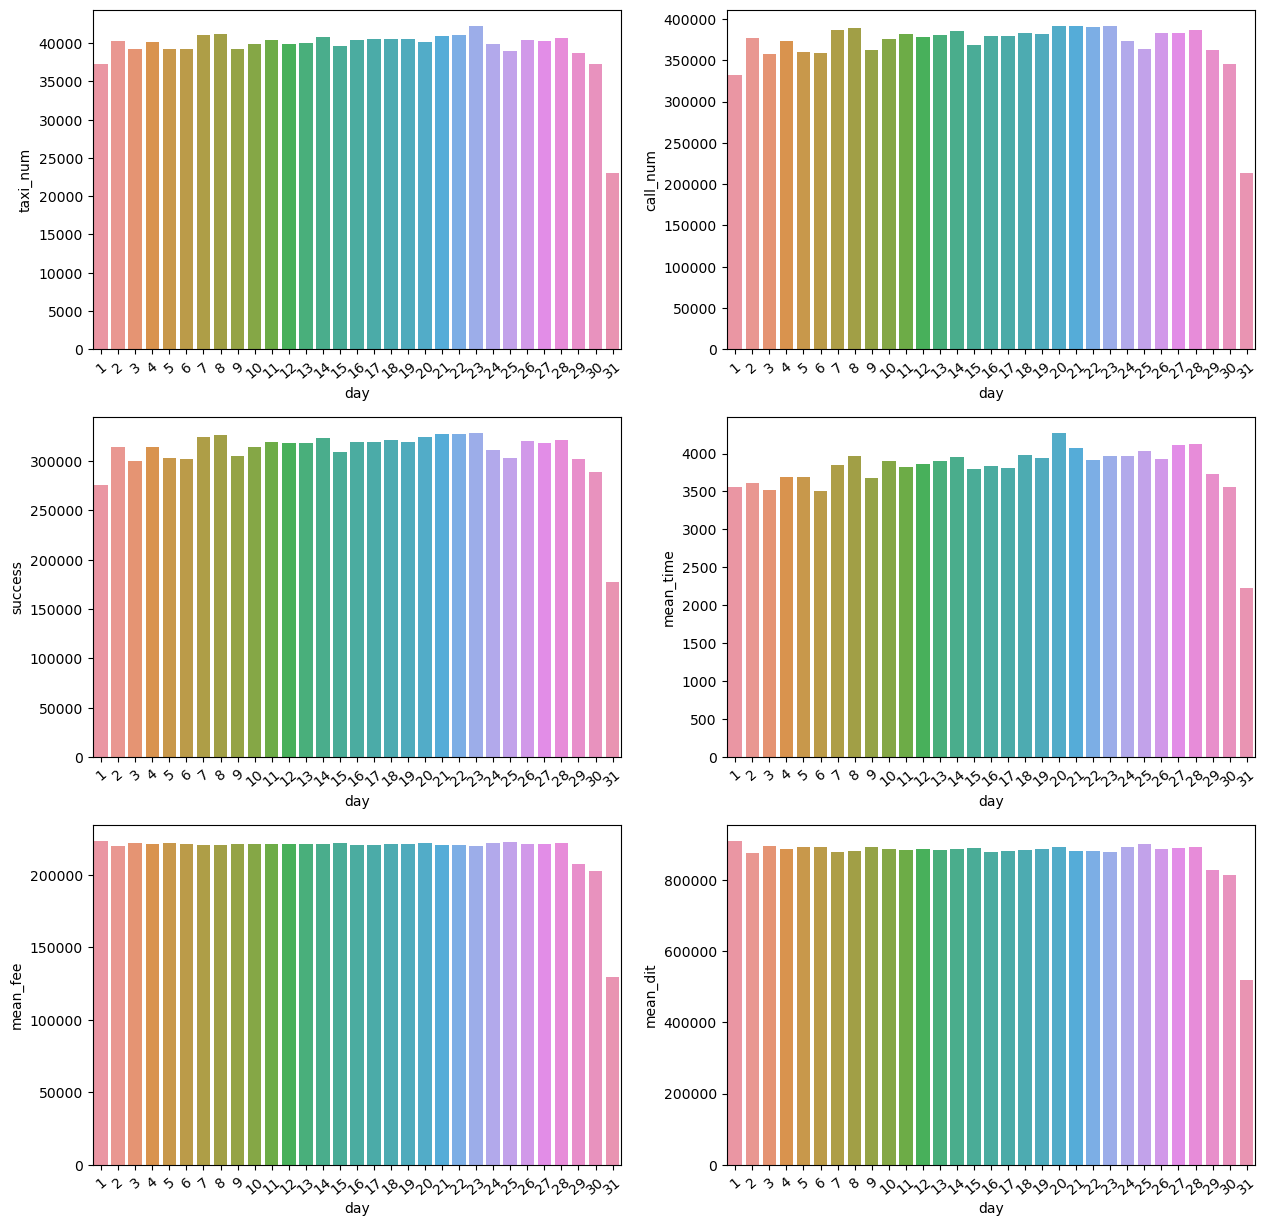

In [162]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
plt.figure(figsize=(15,15))
by = 'day'
x_size =3
y_size= 2
plt.subplot(x_size,y_size,1)
feature = 'taxi_num'
check_ft_by(by,feature)

plt.subplot(x_size,y_size,2)
feature = 'call_num'
check_ft_by(by,feature)

plt.subplot(x_size,y_size,3)
feature = 'success'
check_ft_by(by,feature)

plt.subplot(x_size,y_size,4)
feature = 'mean_time'
check_ft_by(by,feature)

plt.subplot(x_size,y_size,5)
feature = 'mean_fee'
check_ft_by(by,feature)

plt.subplot(x_size,y_size,6)
feature = 'mean_dit'
check_ft_by(by,feature)

* 접수건, 탑승건

* 대기시간

* 운임

* 이동거리

### (3) 요일별

* 차량 운행수

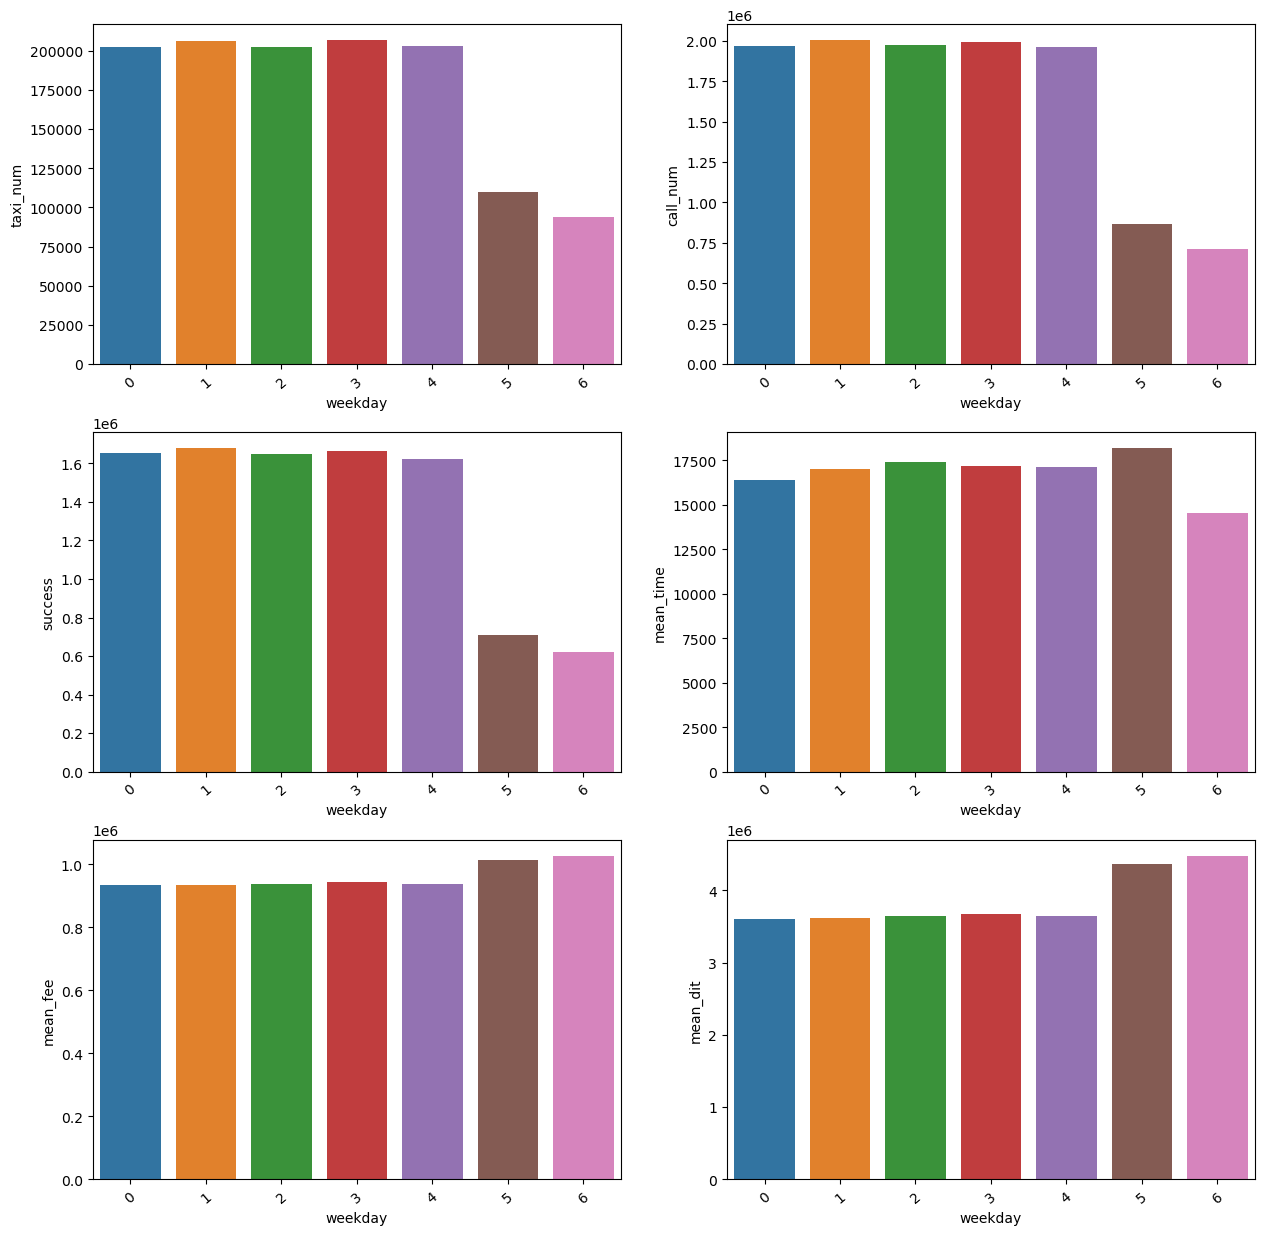

In [163]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
col_list = ['taxi_num', 'call_num', 'success', 'mean_time', 'mean_fee', 'mean_dit']
by = 'weekday'
plt.figure(figsize=(15,15))
x_size = 3
y_size = 2
for i in range(len(col_list)):
    feature = col_list[i]
    plt.subplot(x_size, y_size, i+1)
    check_ft_by(by, feature)

# monday = 0, sunday = 6

* 토요일의 평균 대기 시간이 가장 길었다.
* 주말에 이동거리가 길어지면서 비용도 늘어남

* 접수건, 탑승건

* 대기시간

* 운임

* 이동거리

### (4) 월별

* 차량 운행수

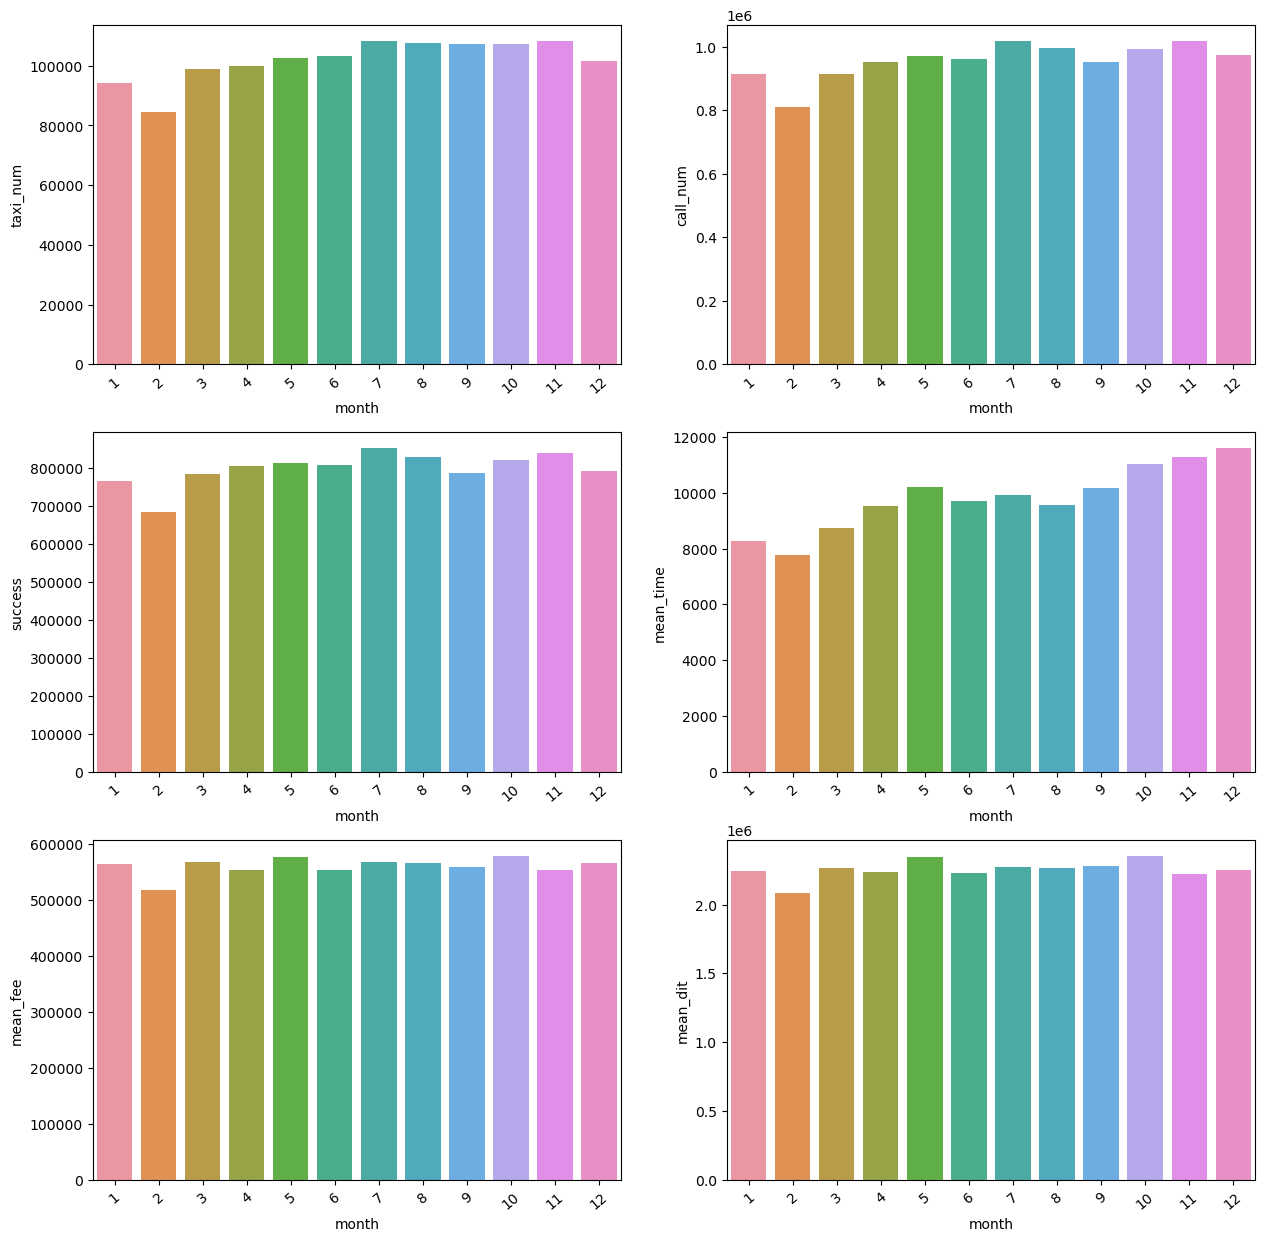

In [164]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
col_list = ['taxi_num', 'call_num', 'success', 'mean_time', 'mean_fee', 'mean_dit']
by = 'month'
plt.figure(figsize=(15,15))
x_size = 3
y_size = 2
for i in range(len(col_list)):
    feature = col_list[i]
    plt.subplot(x_size, y_size, i+1)
    check_ft_by(by, feature)



* 연말에 운행 차량 대수는 그대로인데, 접수건이 늘어남 -> 대기시간 늘어남
* 12월에 운행 차량 대수가 적어짐 ->  대기시간이 늘어남

* 접수건, 탑승건

* 대기시간

* 운임

* 이동거리

### (5) 연도별

* 차량 운행수

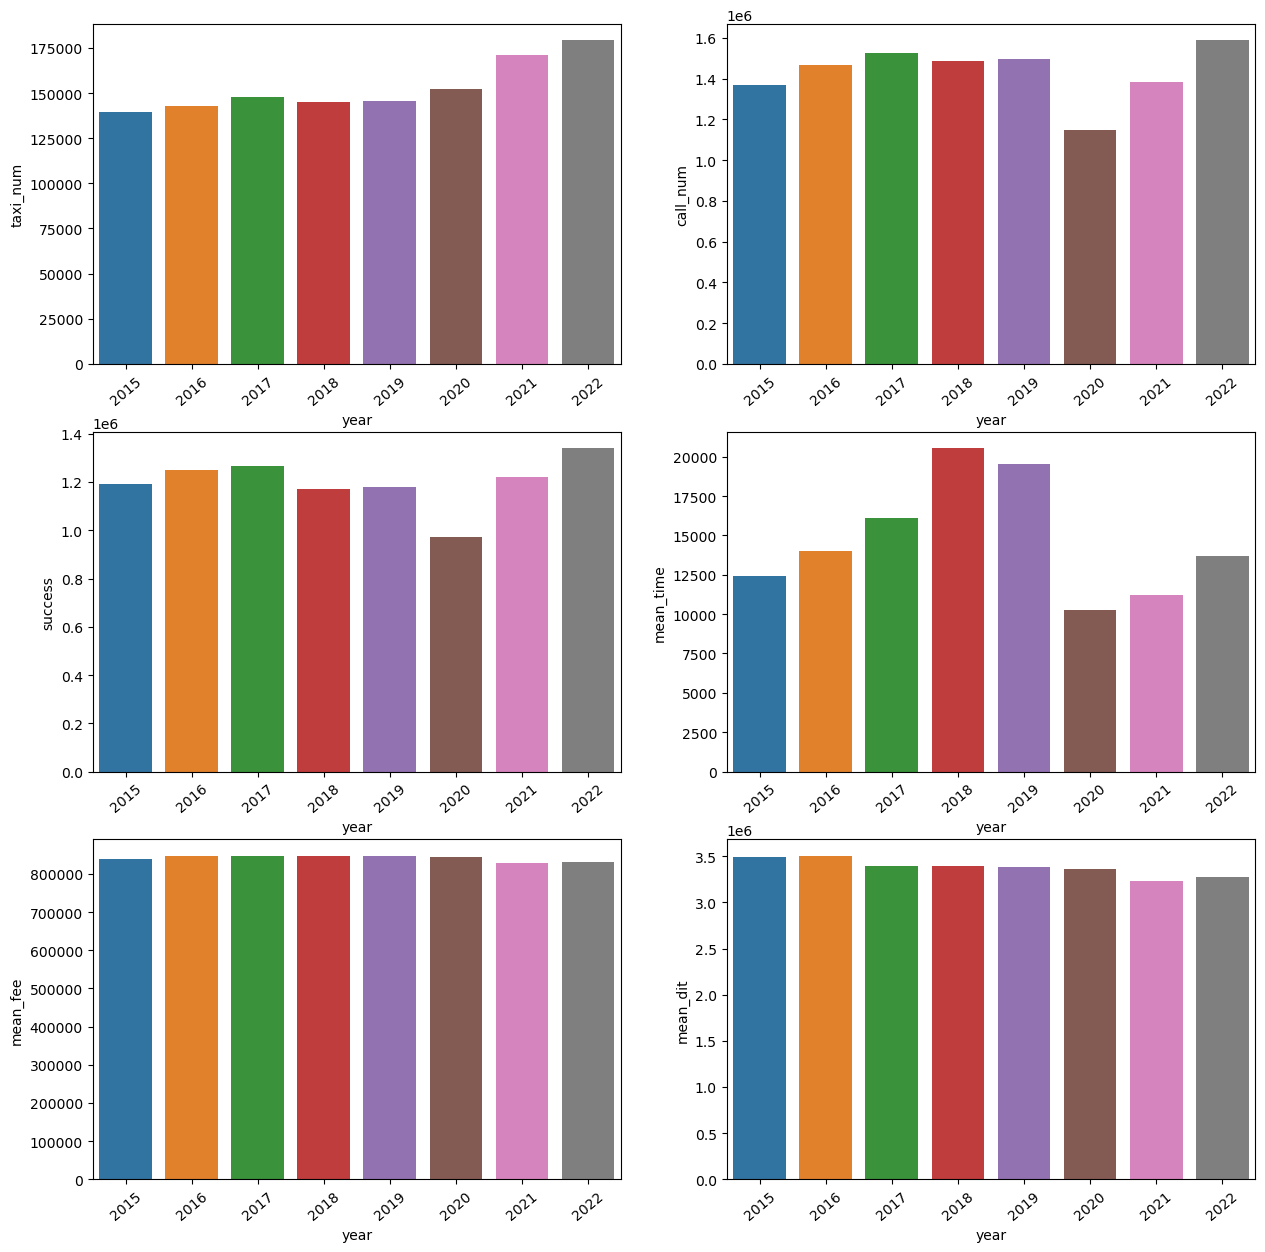

In [165]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
col_list = ['taxi_num', 'call_num', 'success', 'mean_time', 'mean_fee', 'mean_dit']
by = 'year'
plt.figure(figsize=(15,15))
x_size = 3
y_size = 2
for i in range(len(col_list)):
    feature = col_list[i]
    plt.subplot(x_size, y_size, i+1)
    check_ft_by(by, feature)



* 2020년 코로나로 인한 야외활동 자제로 call 횟수 줄어듬
* 2021년부터 taxi 대수 증가와 함께 대기 시간도 줄어듦

* 접수건, 탑승건

## 3.데이터 구조 만들기

* **세부요구사항**
    * 조건 : 
        * 목표 : 전날 저녁, 다음날 평균 대기시간을 예측하고자 합니다.
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
    * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙입니다.

### (1) target 만들기
* 예측하는 날짜, 대기시간(target)으로 기준을 잡습니다.

In [166]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
# 익일의 대기시간(waiting time)을 오늘의 데이터를 활용하여 예측 해야하는 대상(target)으로 설정
target = 'mean_time'


### (2) 날씨 데이터 붙이기
* merge를 활용합니다. 기준은 운행정보 입니다.

In [167]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
# 익일의 실제 날씨 데이터를 전일에 발표된 예보데이터로 판단
wt_data['Date'] = pd.to_datetime(wt_data['Date'])
print(wt_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             4018 non-null   datetime64[ns]
 1   temp_max         4018 non-null   float64       
 2   temp_min         4018 non-null   float64       
 3   rain(mm)         4018 non-null   float64       
 4   humidity_max(%)  4018 non-null   float64       
 5   humidity_min(%)  4018 non-null   float64       
 6   sunshine(MJ/m2)  4018 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 219.9 KB
None


In [168]:
df = pd.merge(taxi_data, wt_data, how='inner')
# df_copy = df.copy()

In [169]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
df.head(2)


,Date,taxi_num,call_num,success,mean_time,mean_fee,mean_dit,weekday,month,year,day,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2015-01-01,213,1023,924,23.2,2427,10764,3,1,2015,1,-4.3,-9.8,0.0,52.0,33.0,9.79
1,2015-01-02,420,3158,2839,17.2,2216,8611,4,1,2015,2,-2.0,-8.9,0.0,63.0,28.0,9.07


In [170]:
df.isna().sum() # 결측치 없음

Date               0
taxi_num           0
call_num           0
success            0
mean_time          0
mean_fee           0
mean_dit           0
weekday            0
month              0
year               0
day                0
temp_max           0
temp_min           0
rain(mm)           0
humidity_max(%)    0
humidity_min(%)    0
sunshine(MJ/m2)    0
dtype: int64

### (3) 새로운 feature를 생성해 봅시다.
* 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 그외 새로운 feature 도출 : 최소 2개 이상
    * 예 : 공휴일, 최근 7주일간의 평균 대기시간, 탑승률 등

#### 1) 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 요일 이름, 계절이름, 월 이름으로 만드는 경우에는, 변수를 pd.Categorical로 범주형을 만들면서 순서를 지정하는 것이 이후 그래프를 그릴 때 순서대로 표현할 수 있습니다.


In [171]:
# data0['weekday'] = data0['Date'].dt.day_name()
# data0['weekday'] = pd.Categorical(data0['weekday'], 
#                                   categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
# data0['month'] = data0['Date'].dt.month

# data0['season'] = np.where(data0['month'].isin([3,4,5]), 'Spring',
#                            np.where(data0['month'].isin([6,7,8]), 'Summer',
#                                     np.where(data0['month'].isin([9,10,11]), 'Fall', 'Winter')))
# data0['season'] = pd.Categorical(data0['season'], categories=['Spring','Summer','Fall','Winter'])
                                     
# data0['year'] = data0['Date'].dt.year
# data0

In [172]:
df['weekday'] = df['weekday'].map({
    0:'Monday', 
    1:'Tuesday', 
    2:'Wednesday', 
    3:'Thursday', 
    4:'Friday', 
    5:'Saturday',
    6:'Sunday'})
# pd.Categorical(df['weekday'], categories['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

#### 2) 공휴일 정보
* workalendar 패키지를 설치하고, 대한민국 공휴일 정보를 끌어와 봅시다.

* 휴무일 데이터 패키지 설치

In [173]:
# !pip install workalendar

* 간단 사용법

In [174]:
from workalendar.asia import SouthKorea
cal = SouthKorea()
pd.DataFrame(cal.holidays(2023))

,0,1
0,2023-01-01,New year
1,2023-01-21,Korean New Year's Day
2,2023-01-22,Korean New Year's Day
3,2023-01-23,Korean New Year's Day
4,2023-03-01,Independence Day
5,2023-05-05,Children's Day
6,2023-05-26,Buddha's Birthday
7,2023-06-06,Memorial Day
8,2023-08-15,Liberation Day
9,2023-09-28,Midautumn Festival


* 휴무일 데이터셋 만들기 2015 ~ 2022
* 실제로 휴무일에 해당하지만 workalendar 라이브러리에 없는 날짜는 직접 추가해봅시다.
    * 휴무일 장애인 콜택시의 접수건 변화에 대한 특징을 찾아 이를 바탕으로 데이터를 조회하여 찾아볼 수 있음

In [175]:
from workalendar.asia import SouthKorea

cal = SouthKorea()
holiday = pd.DataFrame()
for y in range(2015, 2023) :
    holiday = pd.concat([holiday, pd.DataFrame(cal.holidays(y))], axis = 0)

holiday.columns = ['Date', 'holiday']
holiday['Date'] = pd.to_datetime(holiday['Date'])
holiday['holiday'] = 1
holiday

,Date,holiday
0,2015-01-01,1
1,2015-02-18,1
2,2015-02-19,1
3,2015-02-20,1
4,2015-03-01,1
...,...,...
10,2022-09-10,1
11,2022-09-11,1
12,2022-10-03,1
13,2022-10-09,1


* 기존 데이터에 휴무일 정보 결합하기.
* 휴무일이 아닌 날짜는 0으로 저장하시오.

In [176]:
df = pd.merge(df, holiday, how = 'left')
df = df.fillna({'holiday':0})
print(df.isna().sum())
df.head(3)

Date               0
taxi_num           0
call_num           0
success            0
mean_time          0
mean_fee           0
mean_dit           0
weekday            0
month              0
year               0
day                0
temp_max           0
temp_min           0
rain(mm)           0
humidity_max(%)    0
humidity_min(%)    0
sunshine(MJ/m2)    0
holiday            0
dtype: int64


,Date,taxi_num,call_num,success,mean_time,mean_fee,mean_dit,weekday,month,year,day,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),holiday
0,2015-01-01,213,1023,924,23.2,2427,10764,Thursday,1,2015,1,-4.3,-9.8,0.0,52.0,33.0,9.79,1.0
1,2015-01-02,420,3158,2839,17.2,2216,8611,Friday,1,2015,2,-2.0,-8.9,0.0,63.0,28.0,9.07,0.0
2,2015-01-03,209,1648,1514,26.2,2377,10198,Saturday,1,2015,3,2.4,-9.2,0.0,73.0,37.0,8.66,0.0


#### 3) 7일 이동평균 대기시간
* rolling().mean() 사용

In [177]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
df['mean_time_7days'] = df['mean_time'].rolling(7, min_periods=1).mean()
df.head(4)

,Date,taxi_num,call_num,success,mean_time,mean_fee,mean_dit,weekday,month,year,day,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),holiday,mean_time_7days
0,2015-01-01,213,1023,924,23.2,2427,10764,Thursday,1,2015,1,-4.3,-9.8,0.0,52.0,33.0,9.79,1.0,23.200
1,2015-01-02,420,3158,2839,17.2,2216,8611,Friday,1,2015,2,-2.0,-8.9,0.0,63.0,28.0,9.07,0.0,20.200
2,2015-01-03,209,1648,1514,26.2,2377,10198,Saturday,1,2015,3,2.4,-9.2,0.0,73.0,37.0,8.66,0.0,22.200
3,2015-01-04,196,1646,1526,24.5,2431,10955,Sunday,1,2015,4,8.2,0.2,0.0,89.0,58.0,5.32,0.0,22.775


#### 4) 탑승률

In [178]:

# 탑승률 = success / call_num
# 택시비율 = taxi_num / call_num
df['board_rate'] = df['success'] / df['call_num'] 
df['taxi_rate'] = df['taxi_num'] / df['call_num']
df.head(2)
# quarter 별 분류
bins = [0, 3, 6, 9, 12]
names = ['1','2','3','4']
df['quarter'] = pd.cut(df['month'], bins=bins, labels=names)
df.loc[df['month']==4,:].head(2)

,Date,taxi_num,call_num,success,mean_time,mean_fee,mean_dit,weekday,month,year,...,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),holiday,mean_time_7days,board_rate,taxi_rate,quarter
90,2015-04-01,459,4488,4091,28.4,2250,8994,Wednesday,4,2015,...,10.7,4.8,100.0,41.0,14.44,0.0,31.100000,0.911542,0.102273,2
91,2015-04-02,478,4674,4209,25.6,2219,8554,Thursday,4,2015,...,8.5,26.5,98.0,42.0,11.50,0.0,30.885714,0.900513,0.102268,2


## 4.데이터 저장
* **세부요구사항**
    * joblib 을 사용하여 작업 경로에 정리한 데이터프레임을 저장합니다.
        * 저장파일이름 : data1.pkl

* 날씨데이터 shift 시켜서 붙이기
* temp_max, temp_min, rain(mm), humidity_max(%), humidity_min(%), sunshine(MJ/m2)

In [179]:
df.shape

(2923, 22)

In [180]:
# weather_cols = list(wt_data)[1:]
# df.loc[:,weather_cols] = df.loc[:,weather_cols].shift(-1)

In [181]:
df.tail()

,Date,taxi_num,call_num,success,mean_time,mean_fee,mean_dit,weekday,month,year,...,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),holiday,mean_time_7days,board_rate,taxi_rate,quarter
2918,2022-12-27,669,5635,4654,44.4,2198,8178,Tuesday,12,2022,...,-7.3,0.0,86.0,51.0,10.25,0.0,42.771429,0.825909,0.118722,4
2919,2022-12-28,607,5654,4648,44.8,2161,7882,Wednesday,12,2022,...,-5.4,0.1,92.0,40.0,10.86,0.0,43.514286,0.822073,0.107358,4
2920,2022-12-29,581,5250,4247,52.5,2229,8433,Thursday,12,2022,...,-7.8,0.0,71.0,34.0,10.88,0.0,42.957143,0.808952,0.110667,4
2921,2022-12-30,600,5293,4200,38.3,2183,8155,Friday,12,2022,...,-4.0,0.0,87.0,38.0,10.84,0.0,41.042857,0.793501,0.113357,4
2922,2022-12-31,263,2167,1806,33.7,2318,9435,Saturday,12,2022,...,-4.4,0.0,66.0,66.0,0.00,0.0,41.657143,0.833410,0.121366,4


In [182]:
wt_data.tail()

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
4013,2022-12-27,3.0,-7.3,0.0,86.0,51.0,10.25
4014,2022-12-28,-0.3,-5.4,0.1,92.0,40.0,10.86
4015,2022-12-29,1.7,-7.8,0.0,71.0,34.0,10.88
4016,2022-12-30,2.1,-4.0,0.0,87.0,38.0,10.84
4017,2022-12-31,-4.4,-4.4,0.0,66.0,66.0,0.00


In [183]:
# df.dropna(inplace=True)
# df.isna().sum()

In [195]:
# '.pkl'로 저장
import joblib
joblib.dump(df,'data.pkl')

['data.pkl']

In [185]:
# target 데이터, 즉 다음날 mean_time을 저장해야함
# holiday도 마찬가지, 날씨도 마찬가지
weather_cols = list(wt_data)[1:]
df.loc[:,weather_cols] = df.loc[:,weather_cols].shift(-1)

In [190]:
df['next_mean_time'] = df.loc[:,'mean_time'].shift(-1)
df['holiday'] = df.loc[:,'holiday'].shift(-1)
shift_list = ['month', 'day','year','weekday']
df.loc[:,shift_list] = df.loc[:,shift_list].shift(-1)
df.tail()

,Date,taxi_num,call_num,success,mean_time,mean_fee,mean_dit,weekday,month,year,...,humidity_max(%),humidity_min(%),sunshine(MJ/m2),holiday,mean_time_7days,board_rate,taxi_rate,quarter,next_mean_time,next_holiday
2918,2022-12-27,669,5635,4654,44.4,2198,8178,Wednesday,12.0,2022.0,...,92.0,40.0,10.86,0.0,42.771429,0.825909,0.118722,4,44.8,0.0
2919,2022-12-28,607,5654,4648,44.8,2161,7882,Thursday,12.0,2022.0,...,71.0,34.0,10.88,0.0,43.514286,0.822073,0.107358,4,52.5,0.0
2920,2022-12-29,581,5250,4247,52.5,2229,8433,Friday,12.0,2022.0,...,87.0,38.0,10.84,0.0,42.957143,0.808952,0.110667,4,38.3,0.0
2921,2022-12-30,600,5293,4200,38.3,2183,8155,Saturday,12.0,2022.0,...,66.0,66.0,0.00,0.0,41.042857,0.793501,0.113357,4,33.7,0.0
2922,2022-12-31,263,2167,1806,33.7,2318,9435,None,NaN,NaN,...,NaN,NaN,NaN,NaN,41.657143,0.833410,0.121366,4,NaN,NaN


In [194]:
df.dropna(inplace=True)
drop_cols = ['mean_time', 'next_holiday']+weather_cols+shift_list # 전날 데이터는 drop
df.drop(columns=drop_cols, axis=1)

,Date,taxi_num,call_num,success,mean_fee,mean_dit,holiday,mean_time_7days,board_rate,taxi_rate,quarter,next_mean_time
0,2015-01-01,213,1023,924,2427,10764,0.0,23.200000,0.903226,0.208211,1,17.2
1,2015-01-02,420,3158,2839,2216,8611,0.0,20.200000,0.898987,0.132996,1,26.2
2,2015-01-03,209,1648,1514,2377,10198,0.0,22.200000,0.918689,0.126820,1,24.5
3,2015-01-04,196,1646,1526,2431,10955,0.0,22.775000,0.927096,0.119077,1,26.2
4,2015-01-05,421,4250,3730,2214,8663,0.0,23.460000,0.877647,0.099059,1,23.6
...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2022-12-26,603,5555,4605,2163,7889,0.0,43.485714,0.828983,0.108551,4,44.4
2918,2022-12-27,669,5635,4654,2198,8178,0.0,42.771429,0.825909,0.118722,4,44.8
2919,2022-12-28,607,5654,4648,2161,7882,0.0,43.514286,0.822073,0.107358,4,52.5
2920,2022-12-29,581,5250,4247,2229,8433,0.0,42.957143,0.808952,0.110667,4,38.3
